# Fits to pulsar timing data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numba_stats import norm
from iminuit import Minuit
from collections import defaultdict

In [2]:
df = pd.read_csv('data/pulses_turn_nobl.txt')

## The main fit model
It has three components that are Gaussian distributions and a optional "buzz" as well which is discussed later.

In [3]:
def model(time, a):
    return a[0]*norm.pdf(time, a[1], a[2]) + a[3]*norm.pdf(time, a[4], a[5]) + a[6]*norm.pdf(time, a[7], a[8]) + a[9]

def LSQ(a):
    return np.sum(((model(time, a) - flux)/flux_err)**2)

## Fit and plot a single pulse timing
The measurements come without any error attached to the flux. It is estimated on a pulse-by-pulse basis by using the spread of the flux measurements in the last 25% of the pulse (so effectively assuming that the flux is constant during that period and the only variation observed is from the uncertainty in the flux measurement). It can be seen how the fit provides the optimal fit parameters, their estimated uncertainties and a full correlation matrix.

In [4]:
# Test with the first pulse
first = df[df['pulse_number'] == 0]

flux = first['flux'].to_numpy()
time = first['time'].to_numpy()

# Estimate uncertainty from last quarter of signal
flux_err = np.full_like(flux, np.sqrt(np.var(flux[767:])))


maximum = np.max(flux)
maxpos = time[np.argmax(flux)]

args = np.array([maximum/7.0, maxpos, 0.06,
                 0.2, 1.1, 0.15,
                 0.2, 1.4, 0.04,
                 0.0])

m = Minuit(LSQ, args, name=("A1","μ1", "σ1", "A2","μ2", "σ2", "A3","μ3", "σ3", "n"))
m.errordef=1
m.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 971.9                      │              Nfcn = 370              │
│ EDM = 0.000117 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1   │   1.188   │   0.019   │            │            │         │         │       │
│ 1 │ μ1   │  1.6192   │  0.0010   │            │            │         │         │       │
│ 2 │ σ1   │  0.0594   │  0.0012   │            │            │         │         │       │
│ 3 │ A2   │   0.224   │   0.033   │            │            │         │         │       │
│ 4 │ μ2   │   1.103   │   0.032   │            │            │         │         │       │
│ 5 │ σ2   │   0.181   │   0.028   │            │            │         │         │       │
│ 6 │ A3   │   0.202   │   0.024   │            │            │         │         │       │
│ 7 │ μ3   │   1.436   │   0.005   │            │            │         │         │       │
│ 8 │ σ3   │   0.051   │   0.005   │            │            │         │         │       │
│ 9 │ n    │   0.101   │   0.017   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │        A1        μ1        σ1        A2        μ2        σ2        A3        μ3        σ3         n │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ A1 │  0.000372   -6.7e-6   16.9e-6    0.1e-3        -0        -0   -0.2e-3 -0.046e-3 -0.045e-3  -0.08e-3 │
│ μ1 │   -6.7e-6  1.01e-06   -0.4e-6   -1.1e-6   -1.7e-6   -0.6e-6    9.2e-6    2.1e-6    2.4e-6   -0.4e-6 │
│ σ1 │   16.9e-6   -0.4e-6  1.31e-06    4.0e-6    2.3e-6    2.0e-6  -12.2e-6   -2.8e-6   -2.8e-6   -2.5e-6 │
│ A2 │    0.1e-3   -1.1e-6    4.0e-6   0.00112    0.0005    0.7e-3   -0.4e-3  0.030e-3 -0.066e-3  -0.22e-3 │
│ μ2 │        -0   -1.7e-6    2.3e-6    0.0005   0.00104    0.5e-3   -0.5e-3  0.037e-3 -0.074e-3        -0 │
│ σ2 │        -0   -0.6e-6    2.0e-6    0.7e-3    0.5e-3  0.000815   -0.4e-3  0.029e-3 -0.060e-3  -0.08e-3 │
│ A3 │   -0.2e-3    9.2e-6  -12.2e-6   -0.4e-3   -0.5e-3   -0.4e-3  0.000576  0.011e-3  0.102e-3         0 │
│ μ3 │ -0.046e-3    2.1e-6   -2.8e-6  0.030e-3  0.037e-3  0.029e-3  0.011e-3  2.45e-05  0.005e-3  0.002e-3 │
│ σ3 │ -0.045e-3    2.4e-6   -2.8e-6 -0.066e-3 -0.074e-3 -0.060e-3  0.102e-3  0.005e-3  2.85e-05  0.003e-3 │
│  n │  -0.08e-3   -0.4e-6   -2.5e-6  -0.22e-3        -0  -0.08e-3         0  0.002e-3  0.003e-3  0.000273 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

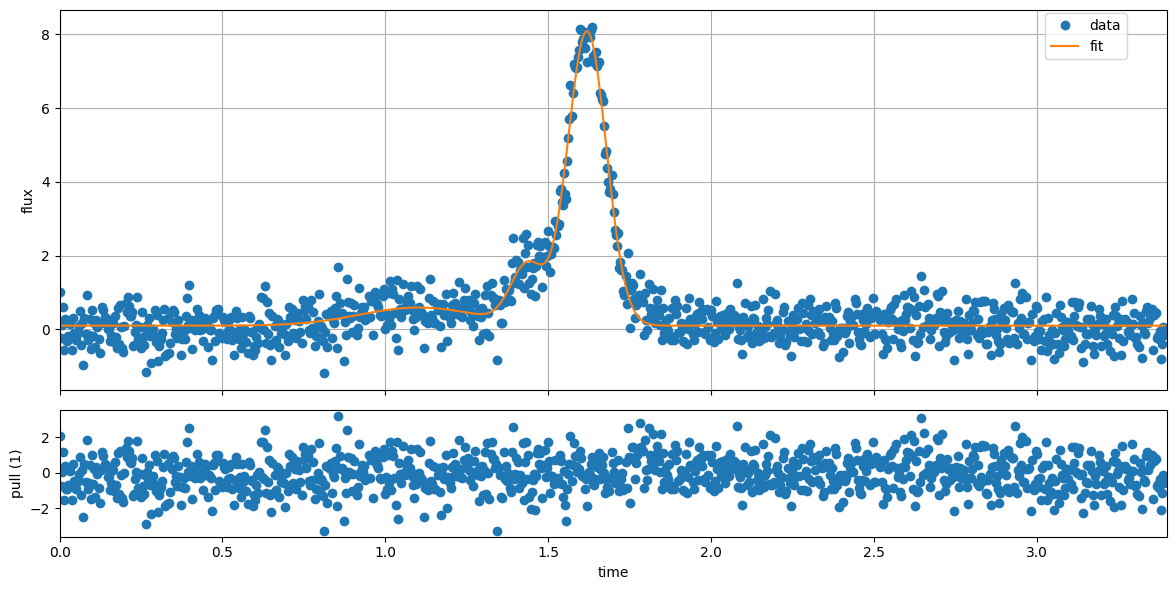

In [5]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(time, flux, marker='o', linestyle='', label="data")

ax1.plot(time, model(time, np.array(m.values)), label = "fit")

ax1.set(xlim=(0, 3.4))
ax1.grid()
ax1.legend(bbox_to_anchor=(0.97,1.01))
ax1.set(ylabel="flux")

rebin = 1
residual = flux - model(time, np.array(m.values))
res_bin = np.mean(np.reshape(residual,(1024//rebin,-1)), axis=1)
pull_bin = res_bin / np.mean(np.reshape(flux_err,(1024//rebin,-1)), axis=1) * np.sqrt(rebin)
time_bin = np.mean(np.reshape(time,(1024//rebin,-1)), axis=1)

ax2.plot(time_bin, pull_bin, marker='o', linestyle='')
ax2.set(ylabel=f"pull ({rebin})", xlabel ="time")

plt.tight_layout()
plt.show()

## Loop over all timing measurements and fit each of them

In [6]:
chi2ndf = []
pulls_good = []
pulls_bad = []
residuals_good = []
residuals_bad = []

fitresult = defaultdict(list)
fitresult_err = defaultdict(list)

ndata = np.max(df['pulse_number'].to_numpy())
for i in range(ndata+1):
    first = df[df['pulse_number'] == i]

    flux = first['flux'].to_numpy()
    time = first['time'].to_numpy()

    # Estimate uncertainty from last quarter of signal
    flux_err = np.full_like(flux, np.sqrt(np.var(flux[767:])))


    maximum = np.max(flux)
    maxpos = time[np.argmax(flux)]
    args = np.array([maximum/7.0, maxpos, 0.06,
                 0.2, 1.1, 0.15,
                 0.2, 1.4, 0.04,
                 0.0])
    m = Minuit(LSQ, args, name=("A1","μ1", "σ1", "A2","μ2", "σ2", "A3","μ3", "σ3", "n"))
    m.errordef=1
    m.migrad()
    chi2ndf.append(m.fval / (len(time)-m.nfit))
    residual = flux - model(time, np.array(m.values))
    res_bin = np.mean(np.reshape(residual,(1024//rebin,-1)), axis=1)
    if m.values["μ1"] > 1.600:
        pulls_good.append(res_bin / np.mean(np.reshape(flux_err,(1024//rebin,-1)), axis=1) * np.sqrt(rebin))
        residuals_good.append(res_bin)
    else:   
        pulls_bad.append(res_bin / np.mean(np.reshape(flux_err,(1024//rebin,-1)), axis=1) * np.sqrt(rebin))
        residuals_bad.append(res_bin)

    for p in m.parameters:
        fitresult[p].append(m.values[p])
        fitresult_err[p].append(m.errors[p])

## Investigate the residuals of the fits 
In each time bin, we look at the mean and the spread (RMS) of the residuals. A systematic deviation from a straight line indicates that the fit is perfect. 
- It can be seen that the wide initial peak has a narrower component that we do not catch.
- The main peak has a bit of a tail. 
- If the data is split up depending on its fitted arrival time, then an interesting "buzz" feature is revealed in the residuals. It is only there during the main pulse and has an average amplitude that is just a few percent of the overall amplitude. The zoomed in plots below illustrates it a bit better.

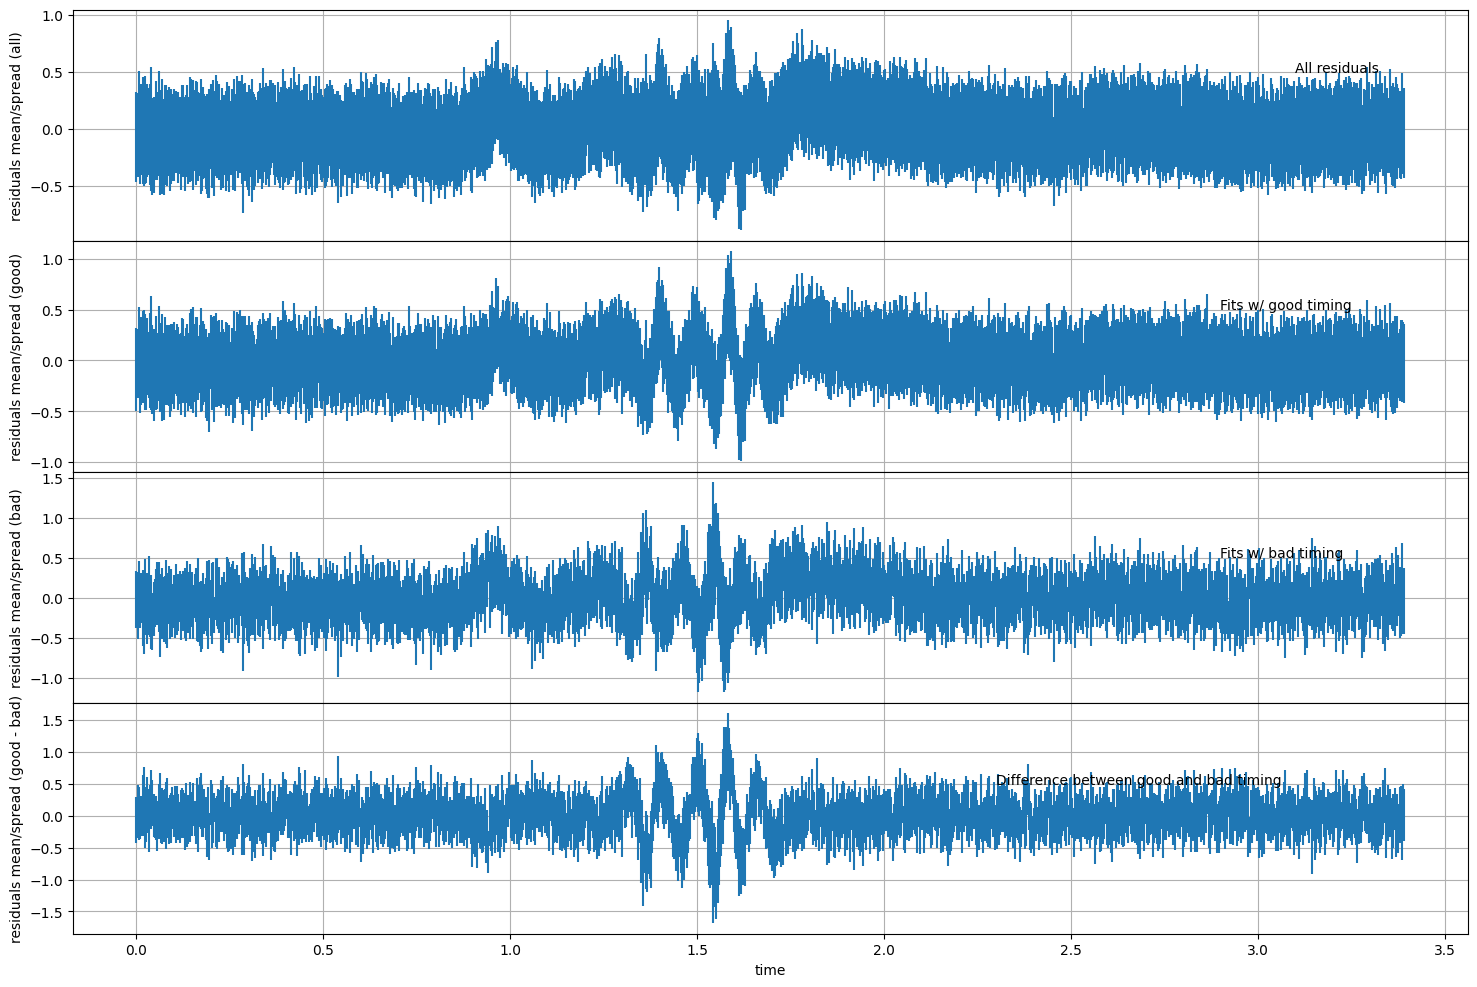

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(18,12), sharex=True, gridspec_kw={'hspace':0})

residuals_good_arr = np.array(residuals_good)
residuals_bad_arr = np.array(residuals_bad)
residuals_all_arr = np.array(residuals_good+residuals_bad)

mean_all = np.mean(residuals_all_arr, axis=0)
spread_all = np.sqrt(np.var(residuals_all_arr, axis=0))
ax1.set(ylabel="residuals mean/spread (all)")
ax1.grid()
ax1.errorbar(time_bin,mean_all,spread_all, linestyle='')
ax1.text(3.1, 0.5, 'All residuals')

mean_good = np.mean(residuals_good_arr, axis=0)
spread_good = np.sqrt(np.var(residuals_good_arr, axis=0))
ax2.set(ylabel="residuals mean/spread (good)")
ax2.grid()
ax2.errorbar(time_bin,mean_good,spread_good, linestyle='')
ax2.text(2.9, 0.5, 'Fits w/ good timing')


mean_bad = np.mean(residuals_bad_arr, axis=0)
spread_bad = np.sqrt(np.var(residuals_bad_arr, axis=0))
ax3.set(ylabel="residuals mean/spread (bad)")
ax3.grid()
ax3.errorbar(time_bin,mean_bad,spread_bad, linestyle='')
ax3.text(2.9, 0.5, 'Fits w/ bad timing')

ax4.set(ylabel="residuals mean/spread (good - bad)", xlabel="time")
ax4.grid()
ax4.errorbar(time_bin,mean_good - mean_bad,spread_bad, linestyle='')
ax4.text(2.3, 0.5, 'Difference between good and bad timing');



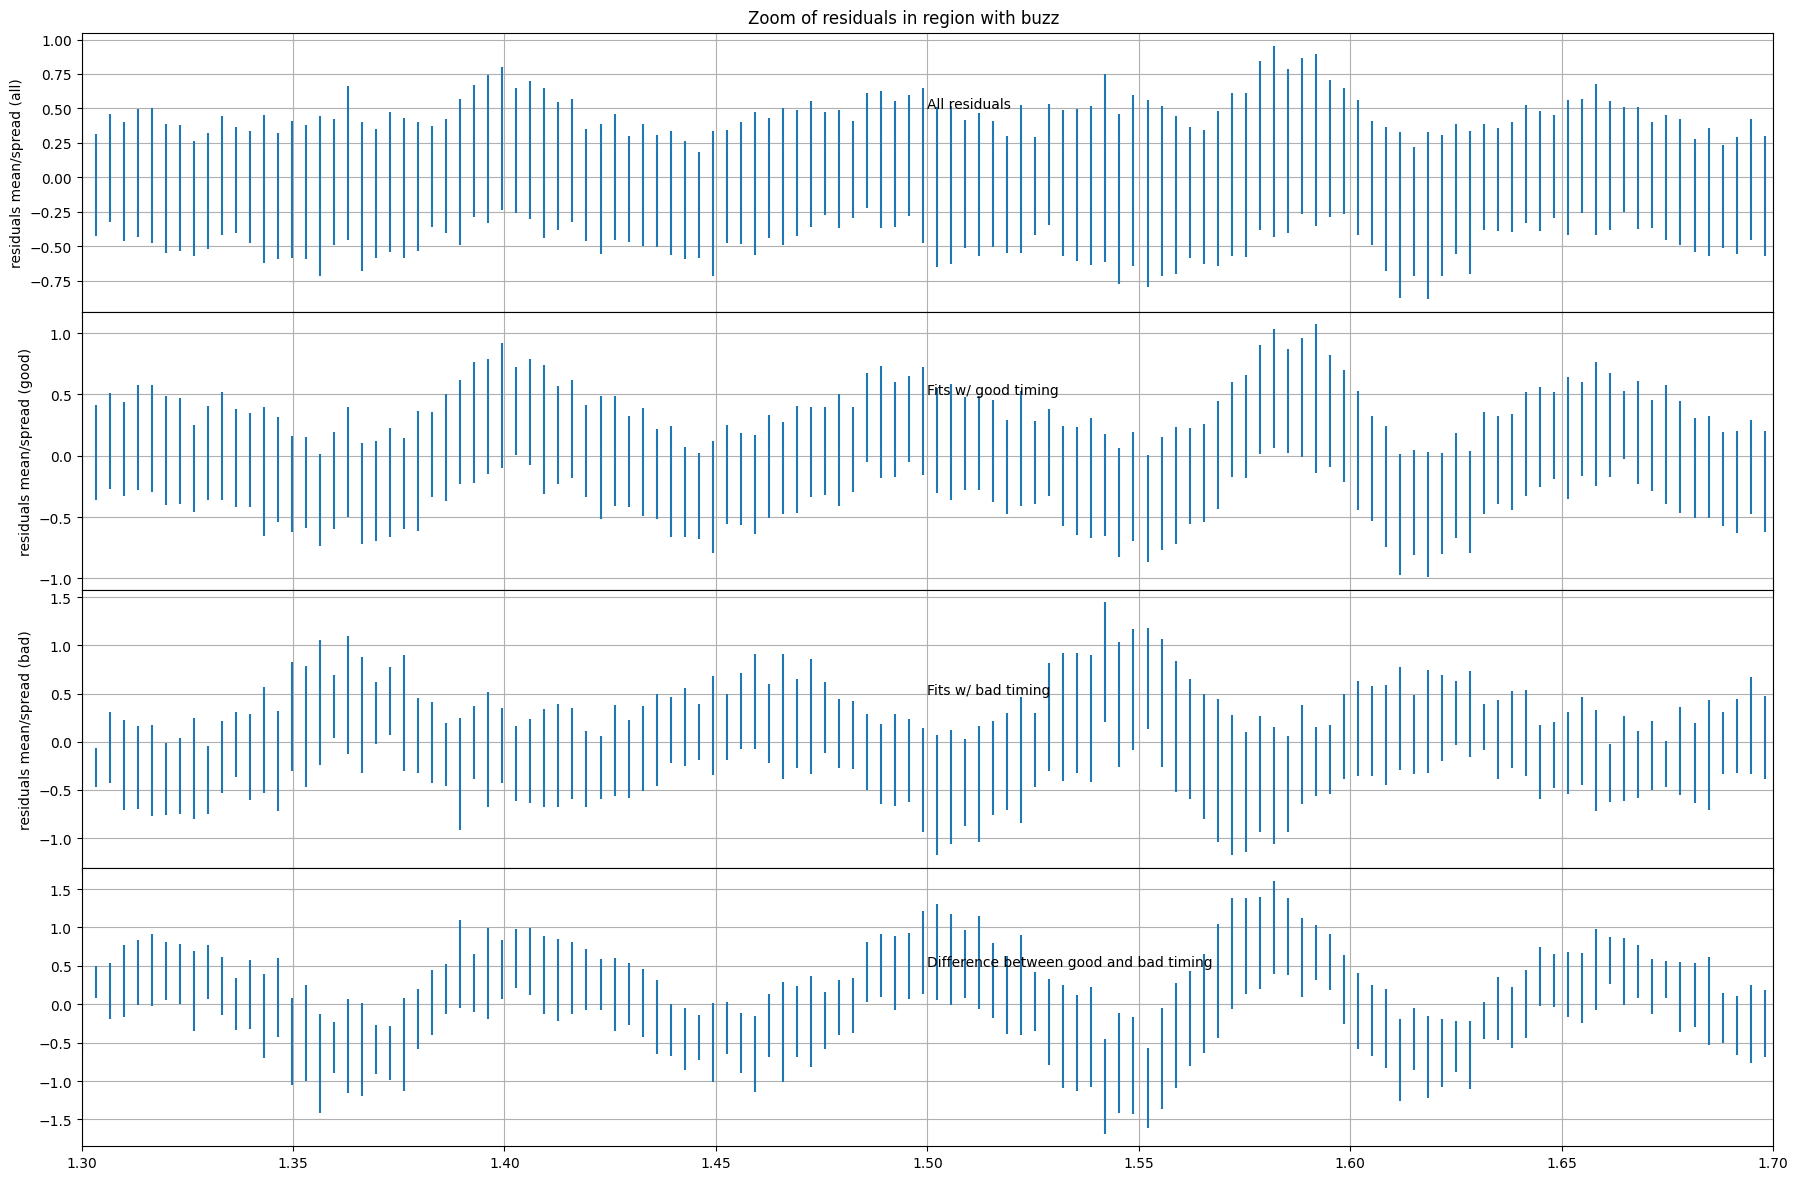

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(18,12), sharex=True, gridspec_kw={'hspace':0})
fig.suptitle("Zoom of residuals in region with buzz")
ax1.set(ylabel="residuals mean/spread (all)")
ax1.errorbar(time_bin,mean_all,spread_all, linestyle='')
ax1.set_xlim(1.3, 1.7)
ax1.grid()
ax1.text(1.5, 0.5, 'All residuals')

ax2.set(ylabel="residuals mean/spread (good)")
ax2.errorbar(time_bin,mean_good,spread_good, linestyle='')
ax2.grid()
ax2.text(1.5, 0.5, 'Fits w/ good timing')

ax3.set(ylabel="residuals mean/spread (bad)")
ax3.errorbar(time_bin,mean_bad,spread_bad, linestyle='')
ax3.grid()
ax3.text(1.5, 0.5, 'Fits w/ bad timing')

ax4.errorbar(time_bin,mean_good - mean_bad,spread_bad, linestyle='')
ax4.grid()
ax4.text(1.5, 0.5, 'Difference between good and bad timing')
plt.tight_layout();


## Fit quality
Here we try to assess the overall fit quality. For a good description of the data and for the correct estimate of uncertainties in the flux, this should peak at 1. If above, it can either indicate that the PDF doesn't have enough flexibility to describe the data or that the statistical uncertainty in the flux measurements is underestimated. If below 1 it can indicate either overfitting or that uncertainties on flux measurements are overestimated.

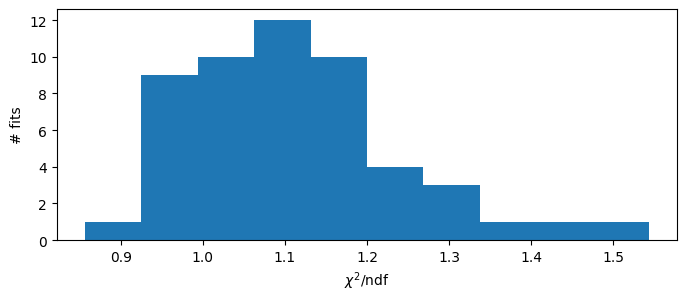

In [9]:
fig, ax = plt.subplots(1, figsize=(8,3))
ax.set(ylabel="# fits", xlabel="$\chi^2/$ndf")
ax.hist(chi2ndf,10);

## Fit parameters
Some plots showing some of the fit parameters for each of the pulsar timings provided.

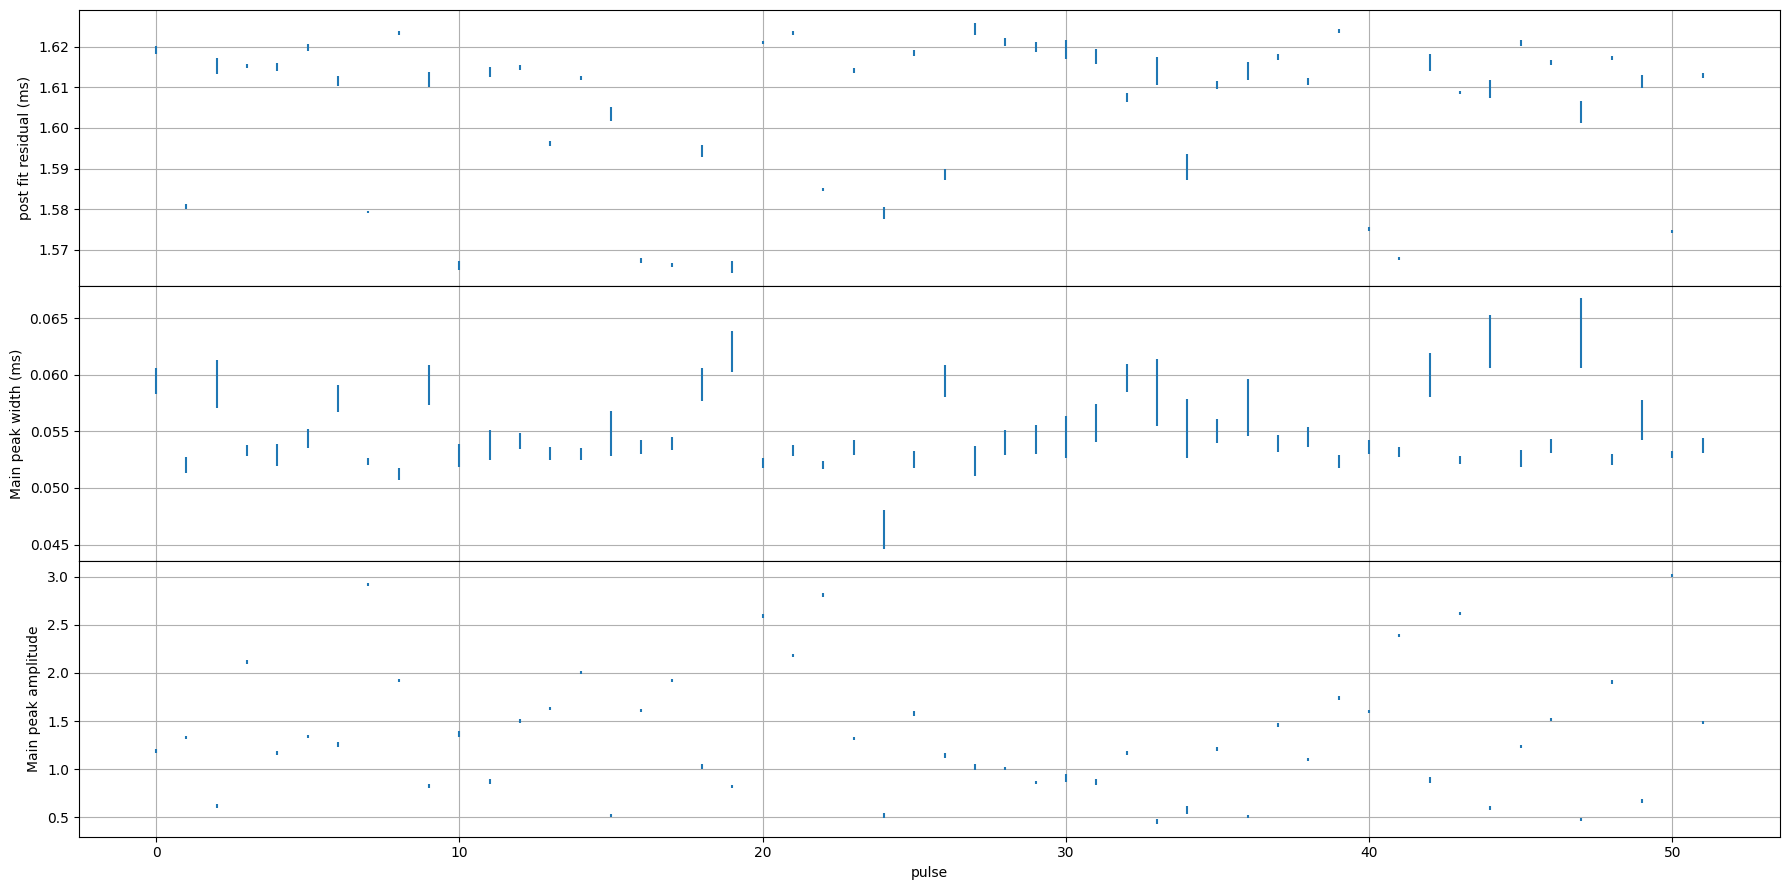

In [10]:
fig, ax = plt.subplots(3, figsize=(18,9), gridspec_kw={'hspace':0})
ax[0].set(ylabel="post fit residual (ms)")
ax[0].errorbar(range(ndata+1), fitresult["μ1"], fitresult_err["μ1"], linestyle='');
ax[0].grid()
ax[1].set(ylabel="Main peak width (ms)")
ax[1].errorbar(range(ndata+1), fitresult["σ1"], fitresult_err["σ1"], linestyle='');
ax[1].grid()
ax[2].set(ylabel="Main peak amplitude", xlabel="pulse")
ax[2].errorbar(range(ndata+1),  fitresult["A1"], fitresult_err["A1"], linestyle='');
ax[2].grid()
plt.tight_layout();


## Buzz investigation
First fit to the overall residual distribution from all the "good timing fits". With a simple oscillation a decent but not good fit is obtained.

In [11]:
def oscillation(time, A, T, phi):
    """A simple oscillation with period amplitude A, period T and phase phi"""
    return A*np.sin(time*2*np.pi/T + phi)

def fitfunc(a):
     return np.sum(((oscillation(timezoom, a[0], a[1] , a[2]) - reszoom)/reserrzoom)**2)

# Try to get a parametrisation of the zoomed "good timing residuals" above
# Cut out the data
mask = ((time < 1.35) | (time > 1.75))
import numpy.ma as ma
timezoom = ma.masked_array(time, mask).compressed() - (1.75+1.35)/2
reszoom = ma.masked_array(mean_good, mask).compressed()
# For the uncertainties we do not need the spread but instead the uncertainty on the mean
reserrzoom = ma.masked_array(spread_good, mask).compressed() / np.sqrt(len(fitresult["μ1"]))

args = np.array([0.2, 0.1, 3.14])

m = Minuit(fitfunc, args, name=("A", "T", "φ"))
m.errordef=1
m.migrad()




┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 550.6                      │              Nfcn = 102              │
│ EDM = 9.5e-07 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   0.254   │   0.007   │            │            │         │         │       │
│ 1 │ T    │ 85.86e-3  │  0.32e-3  │            │            │         │         │       │
│ 2 │ φ    │   5.708   │   0.030   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        A        T        φ │
├───┼────────────────────────────┤
│ A │ 5.36e-05  0.08e-6 -0.01e-3 │
│ T │  0.08e-6 1.04e-07 -1.23e-6 │
│ φ │ -0.01e-3 -1.23e-6 0.000888 │
└───┴────────────────────────────┘

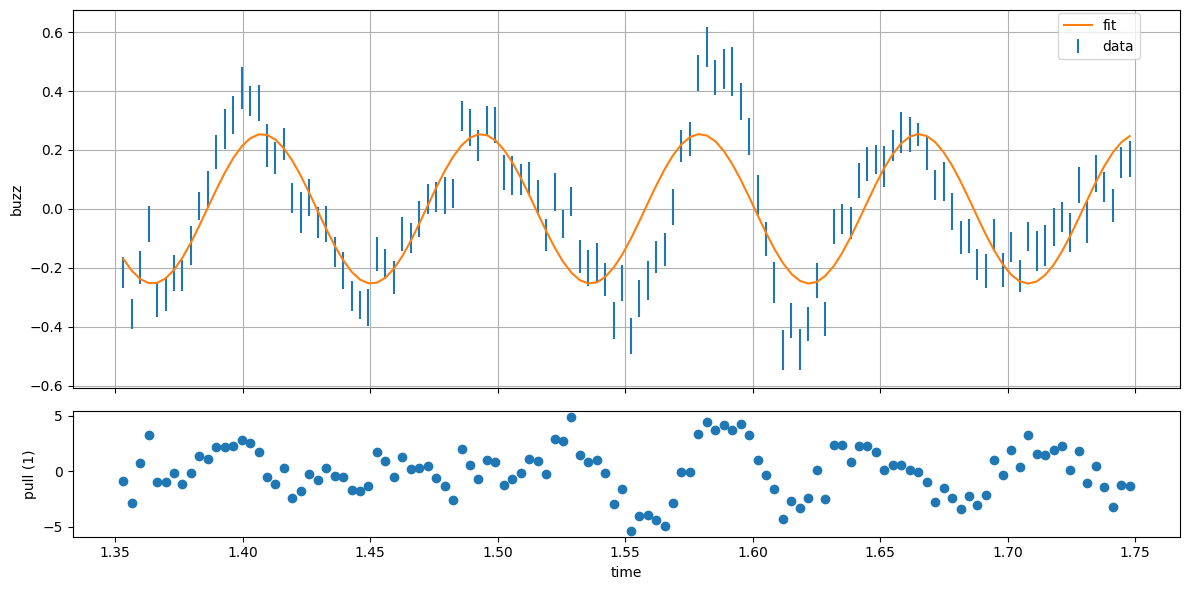

In [12]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.errorbar(timezoom + (1.75+1.35)/2, reszoom, reserrzoom, linestyle='', label="data")

ax1.plot(timezoom + (1.75+1.35)/2, oscillation(timezoom, *np.array(m.values)), label = "fit")

ax1.grid()
ax1.legend(bbox_to_anchor=(0.97,1.01))
ax1.set(ylabel="buzz")

ax2.plot(timezoom + (1.75+1.35)/2, (reszoom - oscillation(timezoom, *np.array(m.values)))/reserrzoom, marker='o', linestyle='')
ax2.set(ylabel=f"pull ({rebin})", xlabel ="time")

plt.tight_layout()
plt.show()

Now fit to just a single residual instead. In this particular fit, we see that the amplitude is different from zero with $3\sigma$ significance. That indicates that we should be able to fit for it as part of the global fit.

In [13]:


reszoom = ma.masked_array(residuals_good[0], mask).compressed()
# Take the spread to be the uncertainty on a single set of residuals
reserrzoom = ma.masked_array(spread_good, mask).compressed()

args = np.array([0.2, 0.1, 3.14])

m = Minuit(fitfunc, args, name=("A", "T", "φ"))
m.errordef=1
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 103                        │              Nfcn = 74               │
│ EDM = 2.42e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   0.18    │   0.05    │            │            │         │         │       │
│ 1 │ T    │  0.0868   │  0.0030   │            │            │         │         │       │
│ 2 │ φ    │   5.86    │   0.29    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        A        T        φ │
├───┼────────────────────────────┤
│ A │  0.00277     8e-6  -0.0007 │
│ T │     8e-6 9.32e-06   -85e-6 │
│ φ │  -0.0007   -85e-6   0.0873 │
└───┴────────────────────────────┘

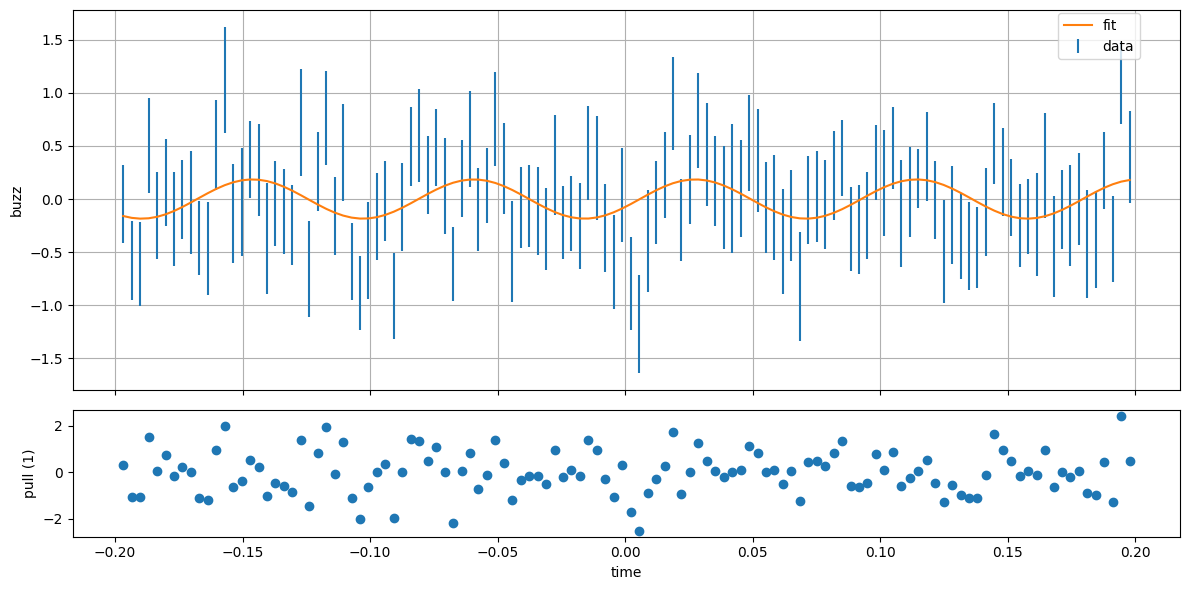

In [14]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.errorbar(timezoom, reszoom, reserrzoom, linestyle='', label="data")

ax1.plot(timezoom, oscillation(timezoom, *np.array(m.values)), label = "fit")

ax1.grid()
ax1.legend(bbox_to_anchor=(0.97,1.01))
ax1.set(ylabel="buzz")

ax2.plot(timezoom, (reszoom - oscillation(timezoom, *np.array(m.values)))/reserrzoom, marker='o', linestyle='')
ax2.set(ylabel=f"pull ({rebin})", xlabel ="time")

plt.tight_layout()
plt.show()

Make a fit that includes the buzz. Fit works fine and the buzz parameters have almost no correlation to the other parameters. Buzz is only really visible on the left edge.

In [15]:
def upstep(time, l, r):
    """Step that goes smoothly from 0 to 1 between l and r"""
    t = (time - l)/(r-l)
    return (t>0)*(t<1)*t*t*(3 - 2 * t) + (t>1)

def downstep(time, l, r):
    """Step that goes smoothly from 1 to 0 between l and r"""
    return upstep(-time, -r, -l)

def tophat(time, l1, r1, l2, r2):
    """A smooth top hat combining the two steps"""
    return upstep(time,l1,r1)*downstep(time,l2,r2)

def oscillation(time, A, T, phi):
    """A simple oscillation with period amplitude A, period T and phase phi"""
    return A*np.sin(time*2*np.pi/T + phi)

def buzz(time, A, T, phi, l1, r2):
    """This is the function that we want to add as the quick oscillation. For the oscillation, time is defined as the centre of the interval to
    reduce correlation between period and phase"""
    r1 = l1+0.1

    l2 = r2-0.1
    return oscillation(time-1.55, A, T, phi)*tophat(time, l1, r1, l2, r2)

def modelbuzz(time, a):
    return a[0]*norm.pdf(time, a[1], a[2]) + a[3]*norm.pdf(time, a[4], a[5]) + a[6]*norm.pdf(time, a[7], a[8]) + a[9] + buzz(time,a[10],a[11], a[12], a[13], a[14])

def LSQbuzz(a):
    return np.sum(((modelbuzz(time, a) - flux)/flux_err)**2)

In [16]:
# Test with the first pulse
first = df[df['pulse_number'] == 0]

flux = first['flux'].to_numpy()
time = first['time'].to_numpy()

# Estimate uncertainty from last quarter of signal
flux_err = np.full_like(flux, np.sqrt(np.var(flux[767:])))


maximum = np.max(flux)
maxpos = time[np.argmax(flux)]

args = np.array([maximum/7.0, maxpos, 0.06,
                 0.2, 1.1, 0.15,
                 0.2, 1.4, 0.04,
                 0.0, 0.2, 0.086, 0.0, 1.3, 1.7])

m = Minuit(LSQbuzz, args, name=("A1","μ1", "σ1", "A2","μ2", "σ2", "A3","μ3", "σ3", "n", "buzz", "T", "φ", 'start', 'stop'))
m.limits["buzz"] = (0, 0.5)
m.limits["start"] = (1.0, 1.5)
m.limits["stop"] = (1.6, 1.9)
m.errordef=1
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 959.5                      │              Nfcn = 758              │
│ EDM = 0.0002 (Goal: 0.0002)      │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1    │   1.187   │   0.020   │            │            │         │         │       │
│ 1 │ μ1    │  1.6194   │  0.0010   │            │            │         │         │       │
│ 2 │ σ1    │  0.0593   │  0.0012   │            │            │         │         │       │
│ 3 │ A2    │   0.222   │   0.034   │            │            │         │         │       │
│ 4 │ μ2    │   1.100   │   0.033   │            │            │         │         │       │
│ 5 │ σ2    │   0.179   │   0.029   │            │            │         │         │       │
│ 6 │ A3    │   0.205   │   0.026   │            │            │         │         │       │
│ 7 │ μ3    │   1.436   │   0.005   │            │            │         │         │       │
│ 8 │ σ3    │   0.052   │   0.006   │            │            │         │         │       │
│ 9 │ n     │   0.101   │   0.017   │            │            │         │         │       │
│ 10│ buzz  │   0.23    │   0.07    │            │            │    0    │   0.5   │       │
│ 11│ T     │   0.089   │   0.004   │            │            │         │         │       │
│ 12│ φ     │   -0.7    │    0.4    │            │            │         │         │       │
│ 13│ start │   1.258   │   0.033   │            │            │    1    │   1.5   │       │
│ 14│ stop  │   1.686   │   0.035   │            │            │   1.6   │   1.9   │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│       │        A1        μ1        σ1        A2        μ2        σ2        A3        μ3        σ3         n      buzz         T         φ     start      stop │
├───────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│    A1 │  0.000392   -7.6e-6   18.7e-6    0.1e-3         0         0   -0.2e-3 -0.048e-3 -0.055e-3  -0.08e-3        -0  0.007e-3   -0.7e-3        -0   -0.1e-3 │
│    μ1 │   -7.6e-6  1.06e-06   -0.5e-6   -2.1e-6   -2.9e-6   -1.6e-6   11.0e-6    2.1e-6    2.9e-6   -0.4e-6    5.0e-6    0.1e-6    0.9e-6    2.0e-6   -0.3e-6 │
│    σ1 │   18.7e-6   -0.5e-6  1.53e-06    5.6e-6    4.1e-6    3.6e-6  -15.2e-6   -3.1e-6   -3.5e-6   -2.8e-6    3.3e-6    1.1e-6 -108.0e-6    0.5e-6  -13.8e-6 │
│    A2 │    0.1e-3   -2.1e-6    5.6e-6   0.00113    0.0005    0.7e-3   -0.5e-3  0.029e-3 -0.077e-3  -0.22e-3   -0.0000  0.009e-3   -0.0003    0.0001   -0.0000 │
│    μ2 │         0   -2.9e-6    4.1e-6    0.0005   0.00106    0.5e-3   -0.5e-3  0.036e-3 -0.086e-3  -0.01e-3   -0.0000  0.009e-3   -0.0003    0.0001   -0.0000 │
│    σ2 │         0   -1.6e-6    3.6e-6    0

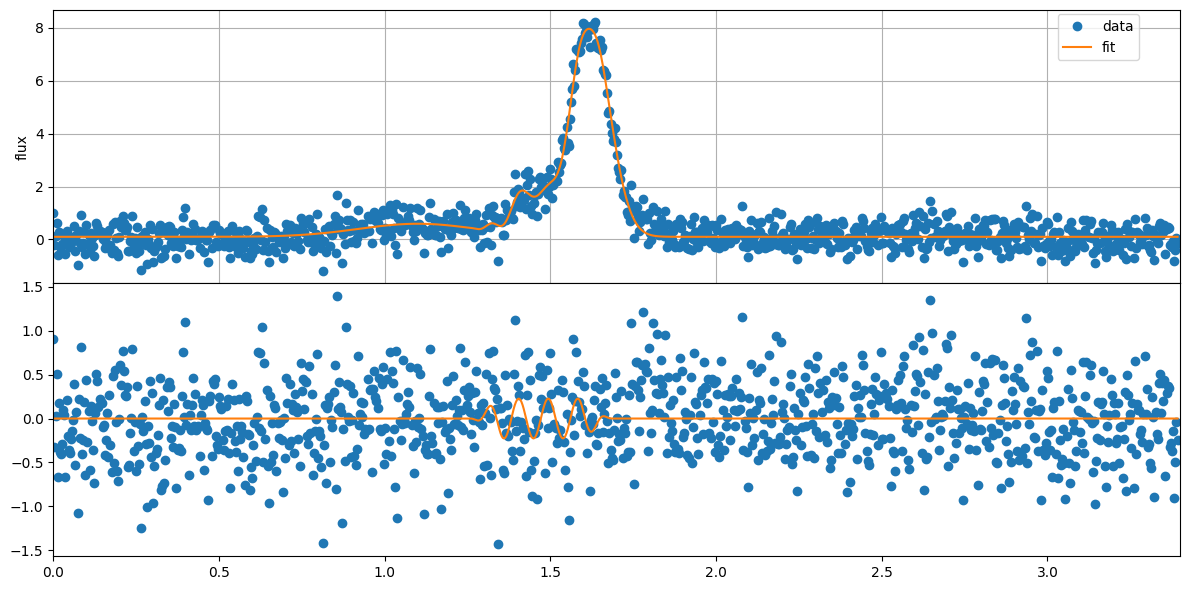

In [17]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,6), sharex=True, gridspec_kw={'hspace':0})

ax1.plot(time, flux, marker='o', linestyle='', label="data")

ax1.plot(time, modelbuzz(time, np.array(m.values)), label = "fit")

ax1.set(xlim=(0, 3.4))
ax1.grid()
ax1.legend(bbox_to_anchor=(0.97,1.01))
ax1.set(ylabel="flux")

# Now try to plot just the buzz part
fitpoints = modelbuzz(time, np.array(m.values))
m.values['A1'] = 0; m.values['A2'] = 0; m.values['A3'] = 0; m.values['n'] = 0;
ax2.plot(time, flux - fitpoints + modelbuzz(time, np.array(m.values)), marker='o', linestyle='', label='buzz data')
ax2.plot(time, modelbuzz(time, np.array(m.values)), label="buzz fit")

plt.tight_layout()
plt.show()

In [18]:
chi2ndf = []
pulls_good = []
pulls_bad = []
residuals_good = []
residuals_bad = []

fitresult = defaultdict(list)
fitresult_err = defaultdict(list)

ndata = np.max(df['pulse_number'].to_numpy())
for i in range(ndata+1):
    first = df[df['pulse_number'] == i]

    flux = first['flux'].to_numpy()
    time = first['time'].to_numpy()

    # Estimate uncertainty from last quarter of signal
    flux_err = np.full_like(flux, np.sqrt(np.var(flux[767:])))


    maximum = np.max(flux)
    maxpos = time[np.argmax(flux)]
    
    args = np.array([maximum/7.0, maxpos, 0.06,
                 0.2, 1.1, 0.15,
                 0.2, 1.4, 0.04,
                 0.0, 0.2, 0.086, 0.0, 1.3, 1.7])

    m = Minuit(LSQbuzz, args, name=("A1","μ1", "σ1", "A2","μ2", "σ2", "A3","μ3", "σ3", "n", "buzz", "T", "φ", 'start', 'stop'))
    m.limits["buzz"] = (0.05, 0.5)
    m.limits["start"] = (1.0, 1.5)
    m.limits["stop"] = (1.65, 1.9)
    m.limits["T"] = (0.001, 0.2)
    m.limits["φ"] = (-np.pi, np.pi)
    m.errordef=1
    m.migrad()
    chi2ndf.append(m.fval / (len(time)-m.nfit))
    residual = flux - modelbuzz(time, np.array(m.values))
    res_bin = np.mean(np.reshape(residual,(1024//rebin,-1)), axis=1)
    if m.values["μ1"] > 1.600:
        pulls_good.append(res_bin / np.mean(np.reshape(flux_err,(1024//rebin,-1)), axis=1) * np.sqrt(rebin))
        residuals_good.append(res_bin)
    else:   
        pulls_bad.append(res_bin / np.mean(np.reshape(flux_err,(1024//rebin,-1)), axis=1) * np.sqrt(rebin))
        residuals_bad.append(res_bin)

    for p in m.parameters:
        fitresult[p].append(m.values[p])
        fitresult_err[p].append(m.errors[p])

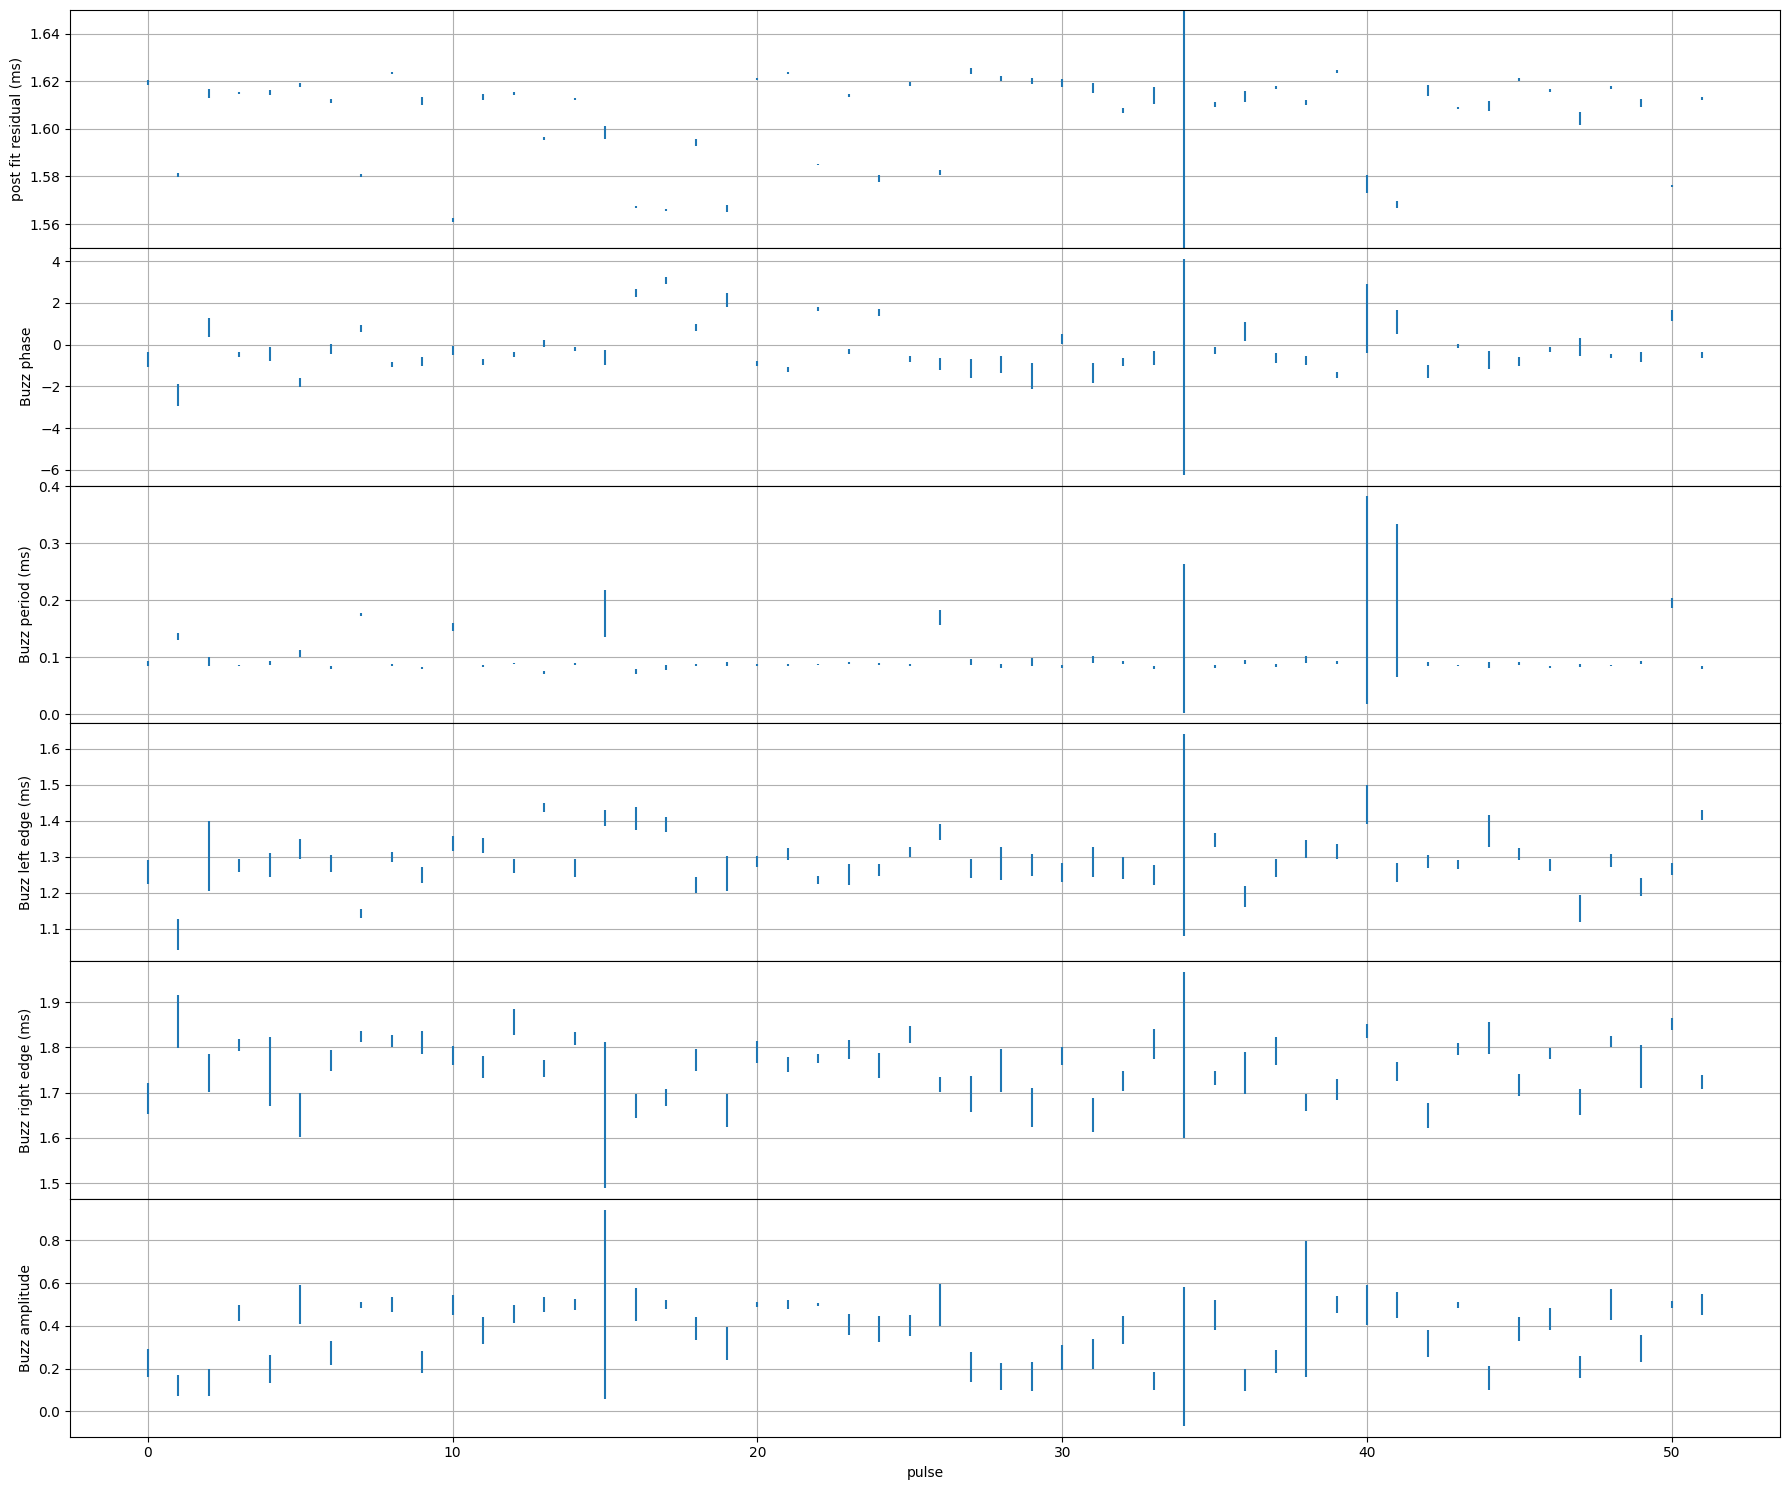

In [19]:
def plotpulse(axx, var, ylabel=None, ylim=None):
    if ylim: axx.set_ylim(ylim)
    if ylabel: axx.set(ylabel=ylabel)
    axx.grid()
    axx.errorbar(range(ndata+1), fitresult[var], fitresult_err[var], linestyle='');
    
fig, ax = plt.subplots(6, figsize=(18, 15), gridspec_kw={'hspace':0})
plotpulse(ax[0], "μ1", "post fit residual (ms)", (1.55, 1.65))
plotpulse(ax[1], "φ", "Buzz phase")
plotpulse(ax[2], "T", "Buzz period (ms)")
plotpulse(ax[3], "start", "Buzz left edge (ms)")
plotpulse(ax[4], "stop", "Buzz right edge (ms)")
plotpulse(ax[5], "buzz", "Buzz amplitude")
ax[5].set(xlabel="pulse")
plt.tight_layout();

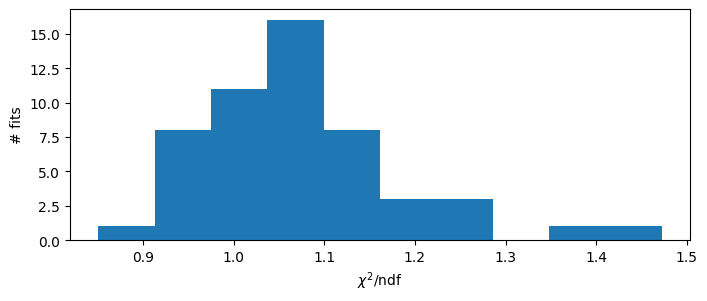

In [20]:
fig, ax = plt.subplots(1, figsize=(8,3))
ax.set(ylabel="# fits", xlabel="$\chi^2/$ndf")
ax.hist(chi2ndf,10);

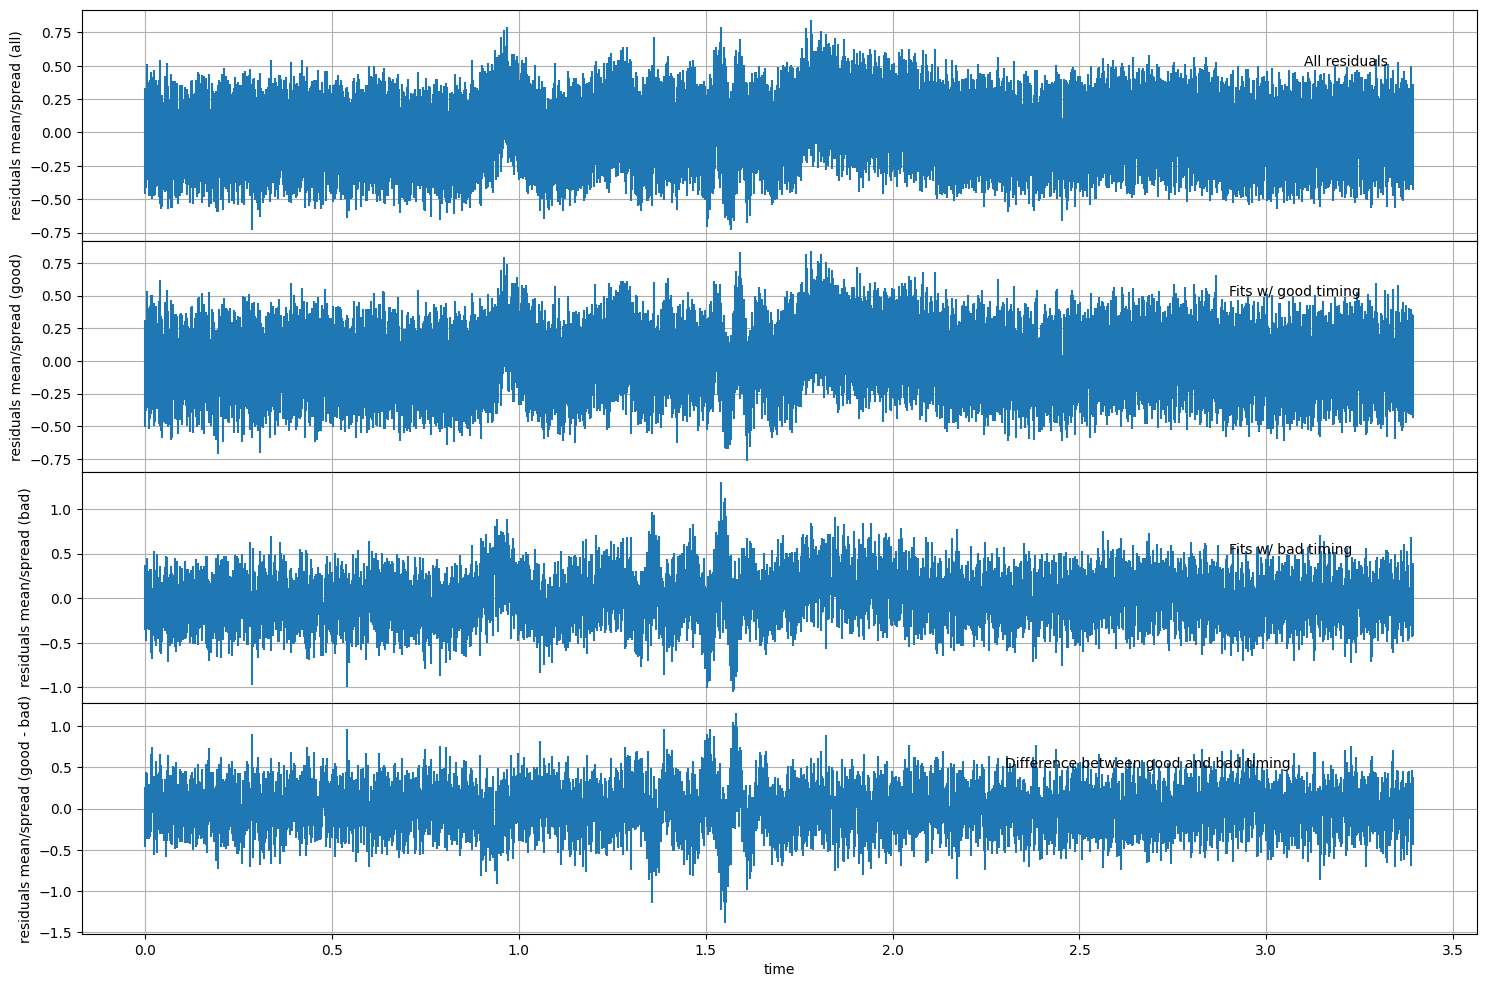

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(18,12), sharex=True, gridspec_kw={'hspace':0})

residuals_good_arr = np.array(residuals_good)
residuals_bad_arr = np.array(residuals_bad)
residuals_all_arr = np.array(residuals_good+residuals_bad)

mean_all = np.mean(residuals_all_arr, axis=0)
spread_all = np.sqrt(np.var(residuals_all_arr, axis=0))
ax1.set(ylabel="residuals mean/spread (all)")
ax1.grid()
ax1.errorbar(time_bin,mean_all,spread_all, linestyle='')
ax1.text(3.1, 0.5, 'All residuals')

mean_good = np.mean(residuals_good_arr, axis=0)
spread_good = np.sqrt(np.var(residuals_good_arr, axis=0))
ax2.set(ylabel="residuals mean/spread (good)")
ax2.grid()
ax2.errorbar(time_bin,mean_good,spread_good, linestyle='')
ax2.text(2.9, 0.5, 'Fits w/ good timing')


mean_bad = np.mean(residuals_bad_arr, axis=0)
spread_bad = np.sqrt(np.var(residuals_bad_arr, axis=0))
ax3.set(ylabel="residuals mean/spread (bad)")
ax3.grid()
ax3.errorbar(time_bin,mean_bad,spread_bad, linestyle='')
ax3.text(2.9, 0.5, 'Fits w/ bad timing')

ax4.set(ylabel="residuals mean/spread (good - bad)", xlabel="time")
ax4.grid()
ax4.errorbar(time_bin,mean_good - mean_bad,spread_bad, linestyle='')
ax4.text(2.3, 0.5, 'Difference between good and bad timing');

